In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from vrnn import utils
from vrnn.models import VanillaModule, HillThermModule, MixedActivationMLP
from vrnn.normalization import NormalizedDataset, NormalizationModule
from vrnn.data_thermal import Dataset3DThermal, VoigtReussThermNormalization
import numpy as np


device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
dtype = torch.float32

data_dir = utils.get_data_dir()

import shutil
import matplotlib
plt.rcParams["text.usetex"] = True if shutil.which('latex') else False
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"

Using device: cpu


In [2]:
# Models to load

# VRNN model
# model_norm_file = data_dir / 'Thermal3D_models/sweep_over_num_samples/vrnn6per_therm3D_norm_20250326_150119.pth'

# Vanilla model
# model_vanilla_file = data_dir / 'Thermal3D_models/sweep_over_num_samples/vann1per_therm3D_20250326_132331.pt'
model_vanilla_file = data_dir / 'Thermal3D_models/vrnn_therm3D_20250320_052451.pt'


In [3]:
# Load hdf5 files
h5_file = data_dir / 'FANS_3D.h5'

dtypes = {'images': torch.bfloat16, 'features': torch.float32, 'targets': torch.float32}

# Load data
feature_idx = None
R_range_train = [1/100., 1/50., 1/20., 1/10., 1/5., 1/2., 2, 5, 10, 20, 50, 100]
# R_range_train = [1/100., 1/5., 5, 100]
train_data = Dataset3DThermal(file_name=h5_file, 
                              R_range=R_range_train, 
                              group='structures_train', 
                              input_mode='descriptors',
                              feature_idx=feature_idx, 
                              device=device,
                              dtypes=dtypes)
R_range_val = np.concatenate([np.arange(2, 101, dtype=int), 1. / np.arange(1, 101, dtype=int)])
val_data = Dataset3DThermal(file_name=h5_file,
                            R_range=R_range_val,
                            group='structures_val',
                            input_mode='descriptors',
                            feature_idx=feature_idx,
                            device=device,
                            dtypes=dtypes,
                            max_samples=2000)

# Fetch data
train_x, train_y = train_data.features, train_data.targets
val_x, val_y = val_data.features, val_data.targets

# Define normalization
features_max = torch.cat([train_data.features, val_data.features], dim=0).max(dim=0)[0]
features_min = torch.cat([train_data.features, val_data.features], dim=0).min(dim=0)[0]
features_min[0],features_max[0]  = 0.0, 1.0 # Dont normalize the first feature (volume fraction)
normalization = VoigtReussThermNormalization(dim=3, features_min=features_min, features_max=features_max)

# Normalize data
train_data_norm = NormalizedDataset(train_data, normalization)
val_data_norm = NormalizedDataset(val_data, normalization)

train_x_norm, train_y_norm = train_data_norm.normalized_x, train_data_norm.normalized_y
val_x_norm, val_y_norm = val_data_norm.normalized_x, val_data_norm.normalized_y

In [4]:
from vrnn.tensortools import unpack_sym

def compute_extended_errors(x, y, y_pred, f1_range=None):
    """
    Computes mean, standard deviation, median, min, max of relative and absolute errors
    for each phase contrast value and returns the full set of errors as well.

    Args:
    - x: Input tensor containing data features.
    - y: Ground truth tensor.
    - y_pred: Predicted output tensor.
    - f1_range: Optional tuple (f1_min, f1_max) to filter data by first feature range (f1).

    Returns:
    - stats: Dictionary with extended statistics (mean, std, median, min, max) 
             for relative and absolute errors for each phase contrast.
    - all_rel_errs: Dictionary with full relative errors for each phase contrast.
    - all_abs_errs: Dictionary with full absolute errors for each phase contrast.
    """
    # Extract unique phase contrasts
    phase_contrasts = torch.unique(x[..., -1]).cpu().numpy()

    # Dictionary to hold statistics
    stats = {}
    all_rel_errs = {}
    all_abs_errs = {}

    for phase_contrast in phase_contrasts:
        # Filter by phase contrast and optional f1 range
        mask = x[:, -1] == phase_contrast
        if f1_range is not None:
            f1_min, f1_max = f1_range
            mask = mask * (x[:, 0] > f1_min) * (x[:, 0] < f1_max)

        # Filtered data
        y_filter = y[mask]
        y_pred_filter = y_pred[mask]

        abs_err = torch.norm(unpack_sym(y_filter, dim=3) - unpack_sym(y_pred_filter, dim=3), 'fro', dim=(1,2))
        rel_err = abs_err / torch.norm(unpack_sym(y_filter, dim=3), 'fro', dim=(1,2))

        # Store the full set of errors
        all_rel_errs[phase_contrast.item()] = rel_err.cpu()
        all_abs_errs[phase_contrast.item()] = abs_err.cpu()

        # Store statistics
        stats[phase_contrast.item()] = {
            'mean_rel_err': rel_err.mean().cpu(),
            'std_rel_err': rel_err.std().cpu(),
            'median_rel_err': rel_err.median().cpu(),
            'min_rel_err': rel_err.min().cpu(),
            'max_rel_err': rel_err.max().cpu(),
            'mean_abs_err': abs_err.mean().cpu(),
            'std_abs_err': abs_err.std().cpu(),
            'median_abs_err': abs_err.median().cpu(),
            'min_abs_err': abs_err.min().cpu(),
            'max_abs_err': abs_err.max().cpu(),
        }

    return stats, all_rel_errs, all_abs_errs

# Lambda function to create the mask for a given phase contrast
tmask = lambda contrast: train_x[:, -1] == contrast
vmask = lambda contrast: val_x[:, -1] == contrast

tnmask = lambda contrast: train_x_norm[:, -1] == contrast
vnmask = lambda contrast: val_x_norm[:, -1] == contrast


In [5]:
# # VRNN normalized model
# ann_model = MixedActivationMLP(input_dim=238, hidden_dims=[512, 256, 128, 64, 32, 16], output_dim=6,
#                                activation_fns=[nn.SELU(), nn.Tanh(), nn.Sigmoid(), nn.Identity()], 
#                                output_activation=nn.Sigmoid(),
#                                use_batch_norm=True)
# model_norm = VanillaModule(ann_model).to(device=device)

# checkpoint = torch.load(model_norm_file, map_location=device)
# model_norm.load_state_dict(checkpoint['model_state_dict'])
# model_norm.eval()

# with torch.inference_mode():
#     train_pred_norm = model_norm(train_x_norm)
#     val_pred_norm = model_norm(val_x_norm)


# VRNN model

# model = NormalizationModule(normalized_module=model_norm, normalization=normalization).to(device=device, dtype=dtype)
model = torch.load(model_vanilla_file, map_location=device, weights_only=False).to(device=device, dtype=dtype)
model.eval()

with torch.inference_mode():
    train_pred = model(train_x)
    val_pred = model(val_x)

rel_err_train = torch.norm(unpack_sym(train_y, dim=3) - unpack_sym(train_pred, dim=3), 'fro', dim=(1,2)) / torch.norm(unpack_sym(train_y, dim=3), 'fro', dim=(1,2))
rel_err_val = torch.norm(unpack_sym(val_y, dim=3) - unpack_sym(val_pred, dim=3), 'fro', dim=(1,2)) / torch.norm(unpack_sym(val_y, dim=3), 'fro', dim=(1,2))

print(f'median rel. error (training) {rel_err_train.median():.4f}, '
      f'median rel. error (validation) {rel_err_val.median():.4f}')
print(f'mean rel. error (training) {rel_err_train.mean():.4f}, '
      f'mean rel. error (validation) {rel_err_val.mean():.4f}')
print(f'max rel. error (training) {rel_err_train.max():.4f}, '
      f'max rel. error (validation) {rel_err_val.max():.4f}')

vrnn_val_stats, vrnn_val_all_rel_errs, vrnn_val_all_abs_errs = compute_extended_errors(val_x, val_y, val_pred)
vrnn_train_stats, vrnn_train_all_rel_errs, vrnn_train_all_abs_errs = compute_extended_errors(train_x, train_y, train_pred)

median rel. error (training) 0.0128, median rel. error (validation) 0.0232
mean rel. error (training) 0.0285, mean rel. error (validation) 0.0439
max rel. error (training) 2.3350, max rel. error (validation) 1.1811


In [6]:
# Hill model

model_hill = HillThermModule(dim=3)
model_hill.eval()

with torch.inference_mode():
    train_hill = model_hill(train_x)
    val_hill = model_hill(val_x)

hill_val_stats, hill_val_all_rel_errs, hill_val_all_abs_errs = compute_extended_errors(val_x, val_y, val_hill)
hill_train_stats, hill_train_all_rel_errs, hill_train_all_abs_errs = compute_extended_errors(train_x, train_y, train_hill)

Skipping phase contrast 1.0 due to low variance


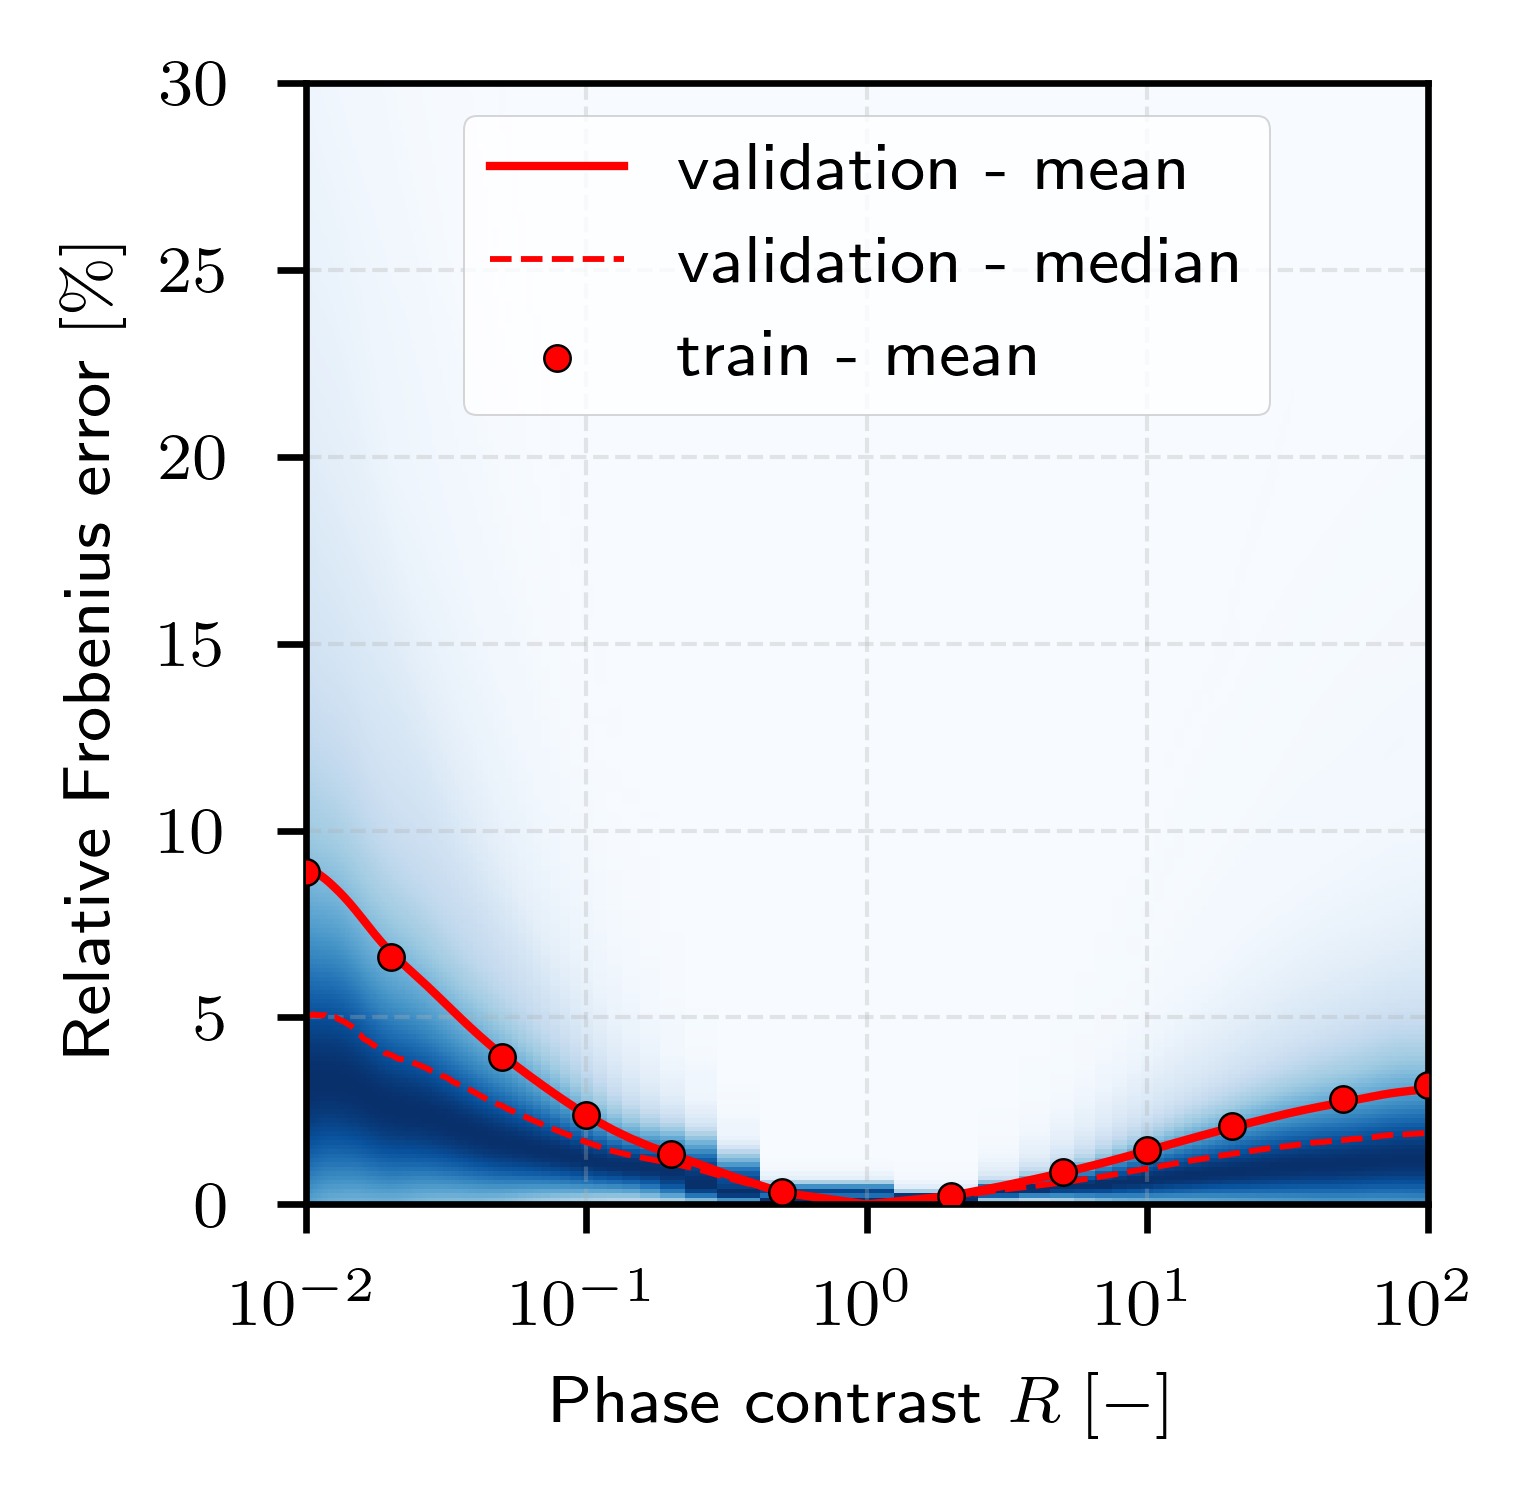

In [7]:
fontsize = 8
plt.rcParams.update({'font.size': fontsize})
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'font.size': fontsize,
})

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_stacked_kde(all_errors, ax, min_variance_threshold=1e-6, fontsize=20):
    phase_contrasts = sorted(all_errors.keys())
    all_error_values = np.concatenate([all_errors[pc].numpy() * 100 for pc in phase_contrasts])
    global_min, global_max = np.min(all_error_values), np.max(all_error_values)
    error_grid = np.linspace(global_min, global_max, 1000)
    
    pc_vals_list, densities_list = [], []
    for pc in phase_contrasts:
        error_values = all_errors[pc].numpy() * 100
        if np.var(error_values) < min_variance_threshold:
            print(f"Skipping phase contrast {pc} due to low variance")
            continue
        density = gaussian_kde(error_values)(error_grid)
        density /= np.max(density)  # normalize
        pc_vals_list.append(np.full_like(error_grid, pc))
        densities_list.append(density)
    
    if len(pc_vals_list) == 0:
        print("No valid phase contrasts to plot")
        return ax

    valid_pcs = np.array([arr[0] for arr in pc_vals_list])
    Z = np.array(densities_list)
    X, Y = np.meshgrid(valid_pcs, error_grid)
    
    c = ax.pcolormesh(X, Y, Z.T, cmap='Blues', shading='auto')
    # cb = ax.figure.colorbar(c, ax=ax)
    # cb.ax.tick_params(labelsize=fontsize)
    
    ax.set_xscale('log')
    ax.set_xlabel(fr"Phase contrast $R \;[-]$", fontsize=fontsize)
    ax.set_ylabel(fr"Relative Frobenius error $[\%]$", fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
    
    plt.tight_layout()
    return ax

fig, ax = plt.subplots(figsize=(6.3/2, 2.5), dpi=600)
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1


# ---------------------- VRNN --------------------------------

plot_stacked_kde(
    vrnn_val_all_rel_errs, 
    ax=ax, 
    fontsize=8
)

# Prepare x and y values for VRNN validation (mean and median relative error)
x_val = np.array(sorted(vrnn_val_stats.keys()))
mean_rel_val = np.array([100 * vrnn_val_stats[k]['mean_rel_err'].item() 
                         for k in sorted(vrnn_val_stats.keys())])
median_rel_val = np.array([100 * vrnn_val_stats[k]['median_rel_err'].item() 
                           for k in sorted(vrnn_val_stats.keys())])

# Plot VRNN validation lines and markers
ax.plot(x_val, mean_rel_val, color='red', linewidth=1, 
           label="validation - mean")
ax.plot(x_val, median_rel_val, color='red', linewidth=0.7, 
           label="validation - median", linestyle='--')

x_train = np.array(sorted(vrnn_train_stats.keys()))
mean_rel_train = np.array([100 * vrnn_train_stats[k]['mean_rel_err'].item() 
                           for k in sorted(vrnn_train_stats.keys())])
ax.scatter(x_train, mean_rel_train, color='red', edgecolor='black', 
              s=10, linewidth=0.3, label="train - mean", zorder=10)

ax.set_xscale('log')
ax.set_xlim(1e-2, 1e2)
ax.set_ylim(0, 30)
ax.legend(fontsize=8, loc='upper center')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
ax.set_box_aspect(1)
ax.minorticks_off()
# ax[0].set_title('Voigt-Reuss NN')


plt.show()

# Save figure in high quality
# fig.savefig('../../overleaf/gfx/therm3d_rel_error.png', dpi=600, bbox_inches='tight')


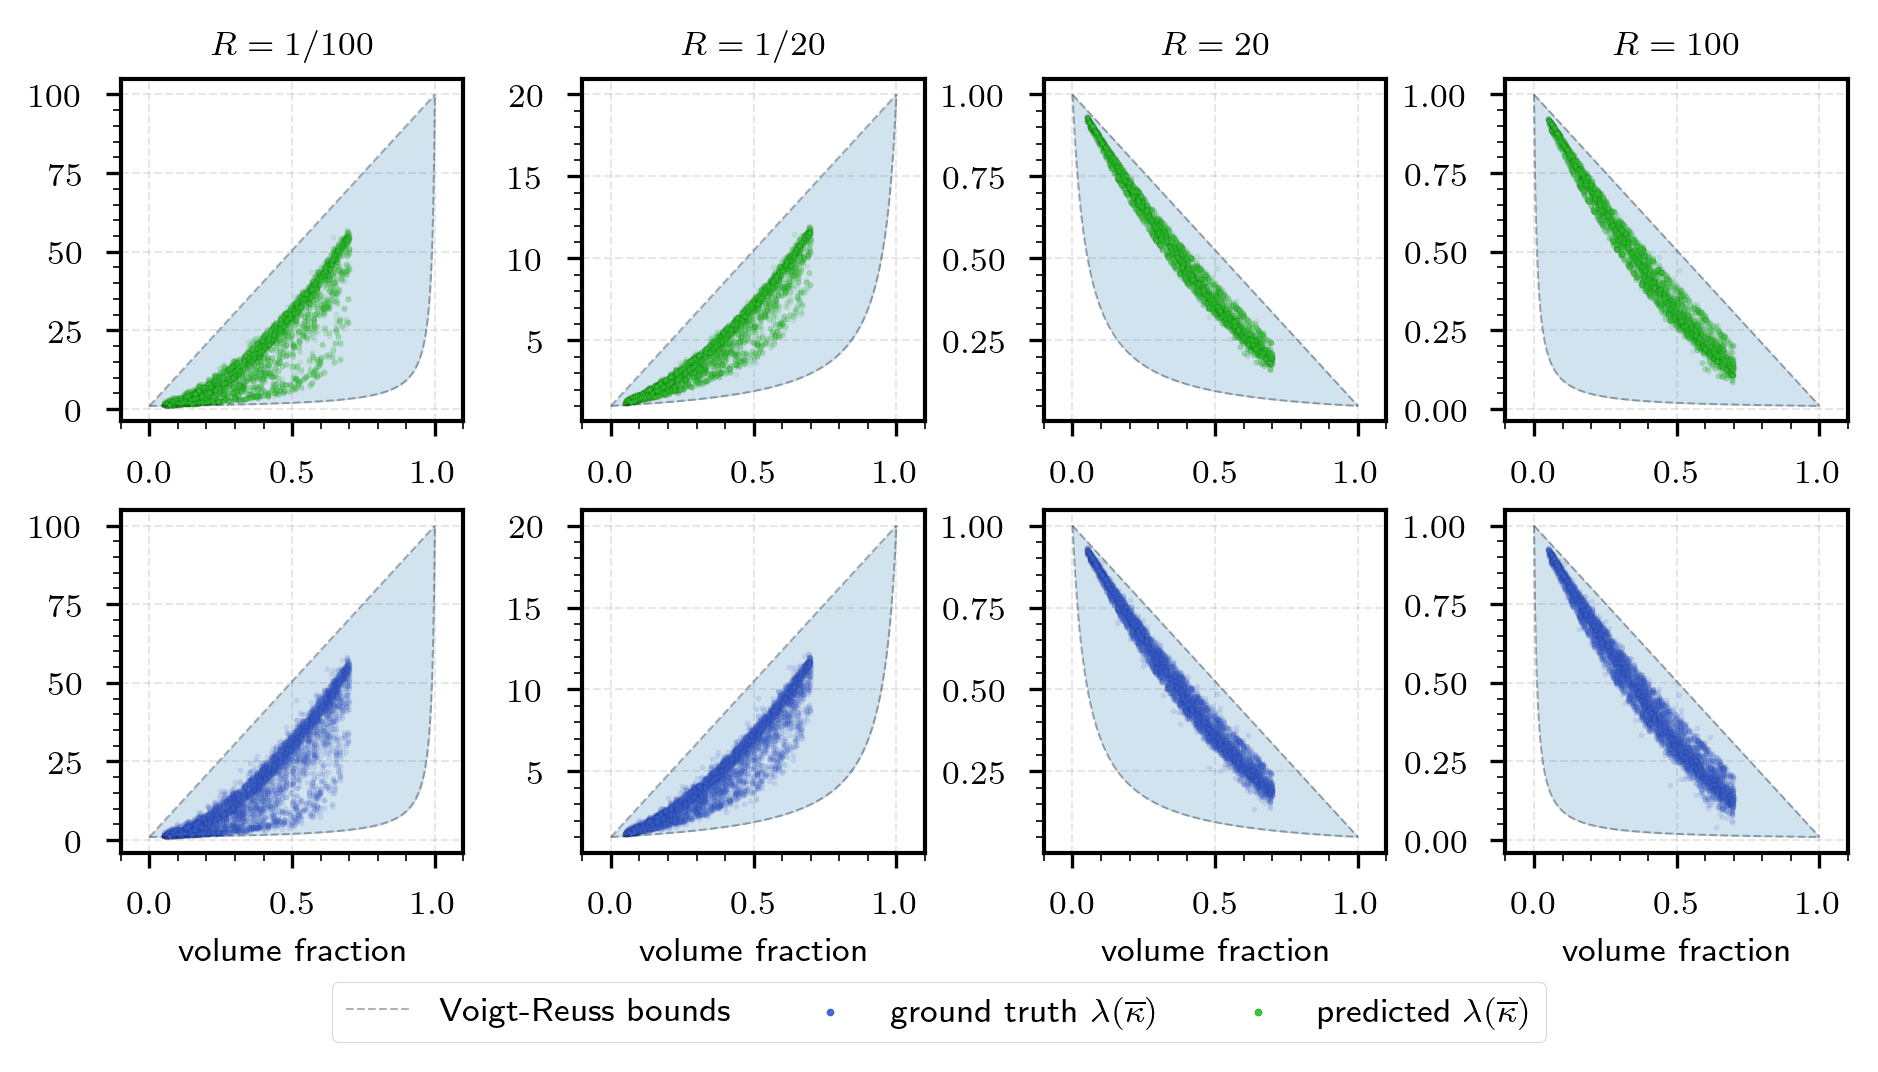

In [10]:
# Global settings
fontsize = 8
plt.rcParams.update({'font.size': fontsize})
plt.style.use('seaborn-v0_8-paper')  # Clean, publication-style theme

def plot_predictions_v2(ax, x, y, pred, phase_contrast, is_last_row=False):
    # Create mask for the specified phase contrast
    mask = x[:, -1] == phase_contrast
    x_filtered = x[mask]
    y_filtered = y[mask]
    pred_filtered = pred[mask]
    
    # Process data for plotting
    volume_fraction = x_filtered[:, 0].cpu().numpy()

    y_matrix = unpack_sym(y_filtered, dim=3)
    pred_matrix = unpack_sym(pred_filtered, dim=3)
    
    # Compute eigenvalues
    y_eigenvalues = torch.linalg.eigvals(y_matrix).real.cpu().numpy()
    pred_eigenvalues = torch.linalg.eigvals(pred_matrix).real.cpu().numpy()
    
    # Generate bounds
    vf = np.linspace(0, 1, 1500)
    voigt_bound = vf - (vf - 1) / phase_contrast
    reuss_bound = 1 / (phase_contrast + vf - phase_contrast * vf)
    
    # Plot data
    vf_repeated = np.repeat(volume_fraction, 3)
    stacked_y = y_eigenvalues.reshape(-1)
    stacked_pred = pred_eigenvalues.reshape(-1)
    
    ax.fill_between(vf, np.flip(voigt_bound), y2=np.flip(reuss_bound), alpha=0.2, color='tab:blue')
    ax.plot(vf, np.flip(voigt_bound), 'k--', linewidth=0.5, alpha=0.3, label='Voigt-Reuss bounds' if is_last_row else None)
    ax.plot( vf, np.flip(reuss_bound), 'k--', linewidth=0.5, alpha=0.3)
    
    # compute the voigt and reuss bound for each entry of vf_repeated
    voigt_bound = (1-vf_repeated) - ((1-vf_repeated) - 1) / phase_contrast
    reuss_bound = 1 / (phase_contrast + (1-vf_repeated) - phase_contrast * (1-vf_repeated))
    
    if is_last_row:
        ax.scatter(vf_repeated, stacked_y, s=1.5, color='royalblue',
                edgecolor='black', linewidth=0.05, alpha=0.15)
        ax.scatter([], [], s=3.0, color='royalblue', edgecolor='black', linewidth=0.05, alpha=1.0,
                label=r'ground truth $\lambda({\overline{\mathbf{\kappa}}})$')
    
    
    
    violation_mask = (stacked_pred > voigt_bound) | (stacked_pred < reuss_bound)
    if not is_last_row:    
        ax.scatter(vf_repeated[~violation_mask], stacked_pred[~violation_mask], s=1.5, color='limegreen',
                    edgecolor='black', linewidth=0.05, alpha=0.15)
    ax.scatter([], [], s=3.0, color='limegreen', edgecolor='black', linewidth=0.05, alpha=1.0,
               label=r'predicted $\lambda({\overline{\mathbf{\kappa}}})$' if is_last_row else None)
    
    
    # # Violations!
    # ax.scatter(vf_repeated[violation_mask], stacked_pred[violation_mask], s=3, color='red',
    #            edgecolor='black', linewidth=0.05, alpha=1.0,
    #           label=r'predicted $\lambda({\overline{\mathbf{\kappa}}})$ violation' if is_last_row else None)

    
    

# Create figure
fig, ax = plt.subplots(2, 4, figsize=(6.3, 3.6), dpi=300)

# Plot data
# contrasts = [1./75, 1./30, 30, 75]
# contrasts = [1./100, 1./20, 20, 100]
contrasts = [1./100, 1./20, 20, 100]
datasets =  [val_pred, val_hill]

for row, pred_data in enumerate(datasets):
    for col, contrast in enumerate(contrasts):
        plot_predictions_v2(ax[row, col], val_x, val_y, pred_data, contrast, is_last_row=(row==1))
        if row == 0:
            # Format first two columns as fractions, last two as regular numbers
            if col < 2:
                ax[row, col].set_title(fr'$R = 1/{int(1/contrast)}$', fontsize=fontsize)
            else:
                ax[row, col].set_title(fr'$R = {int(contrast)}$', fontsize=fontsize)
        # if col == 0:
        #     ax[row, col].set_ylabel('eigenvalues', fontsize=fontsize)
        if row == 1:
            ax[row, col].set_xlabel('volume fraction', fontsize=fontsize)
        ax[row, col].grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        ax[row, col].set_axisbelow(True)
        ax[row, col].set_box_aspect(1.0)
        ax[row, col].set_xlim(-0.1, 1.1)
        ax[row, col].minorticks_on() # Add minor ticks
        

# Add single legend at the bottom
handles, labels = ax[1, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), 
           ncol=4, fontsize=fontsize)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace = -0.2, bottom=0.05)  # Make room for legend

# Save figure
fig.savefig("../../overleaf/gfx/therm3d_predictions_VRbounds.png", 
            bbox_inches='tight', 
            dpi=600,
            metadata={'Creator': '', 'Producer': ''})


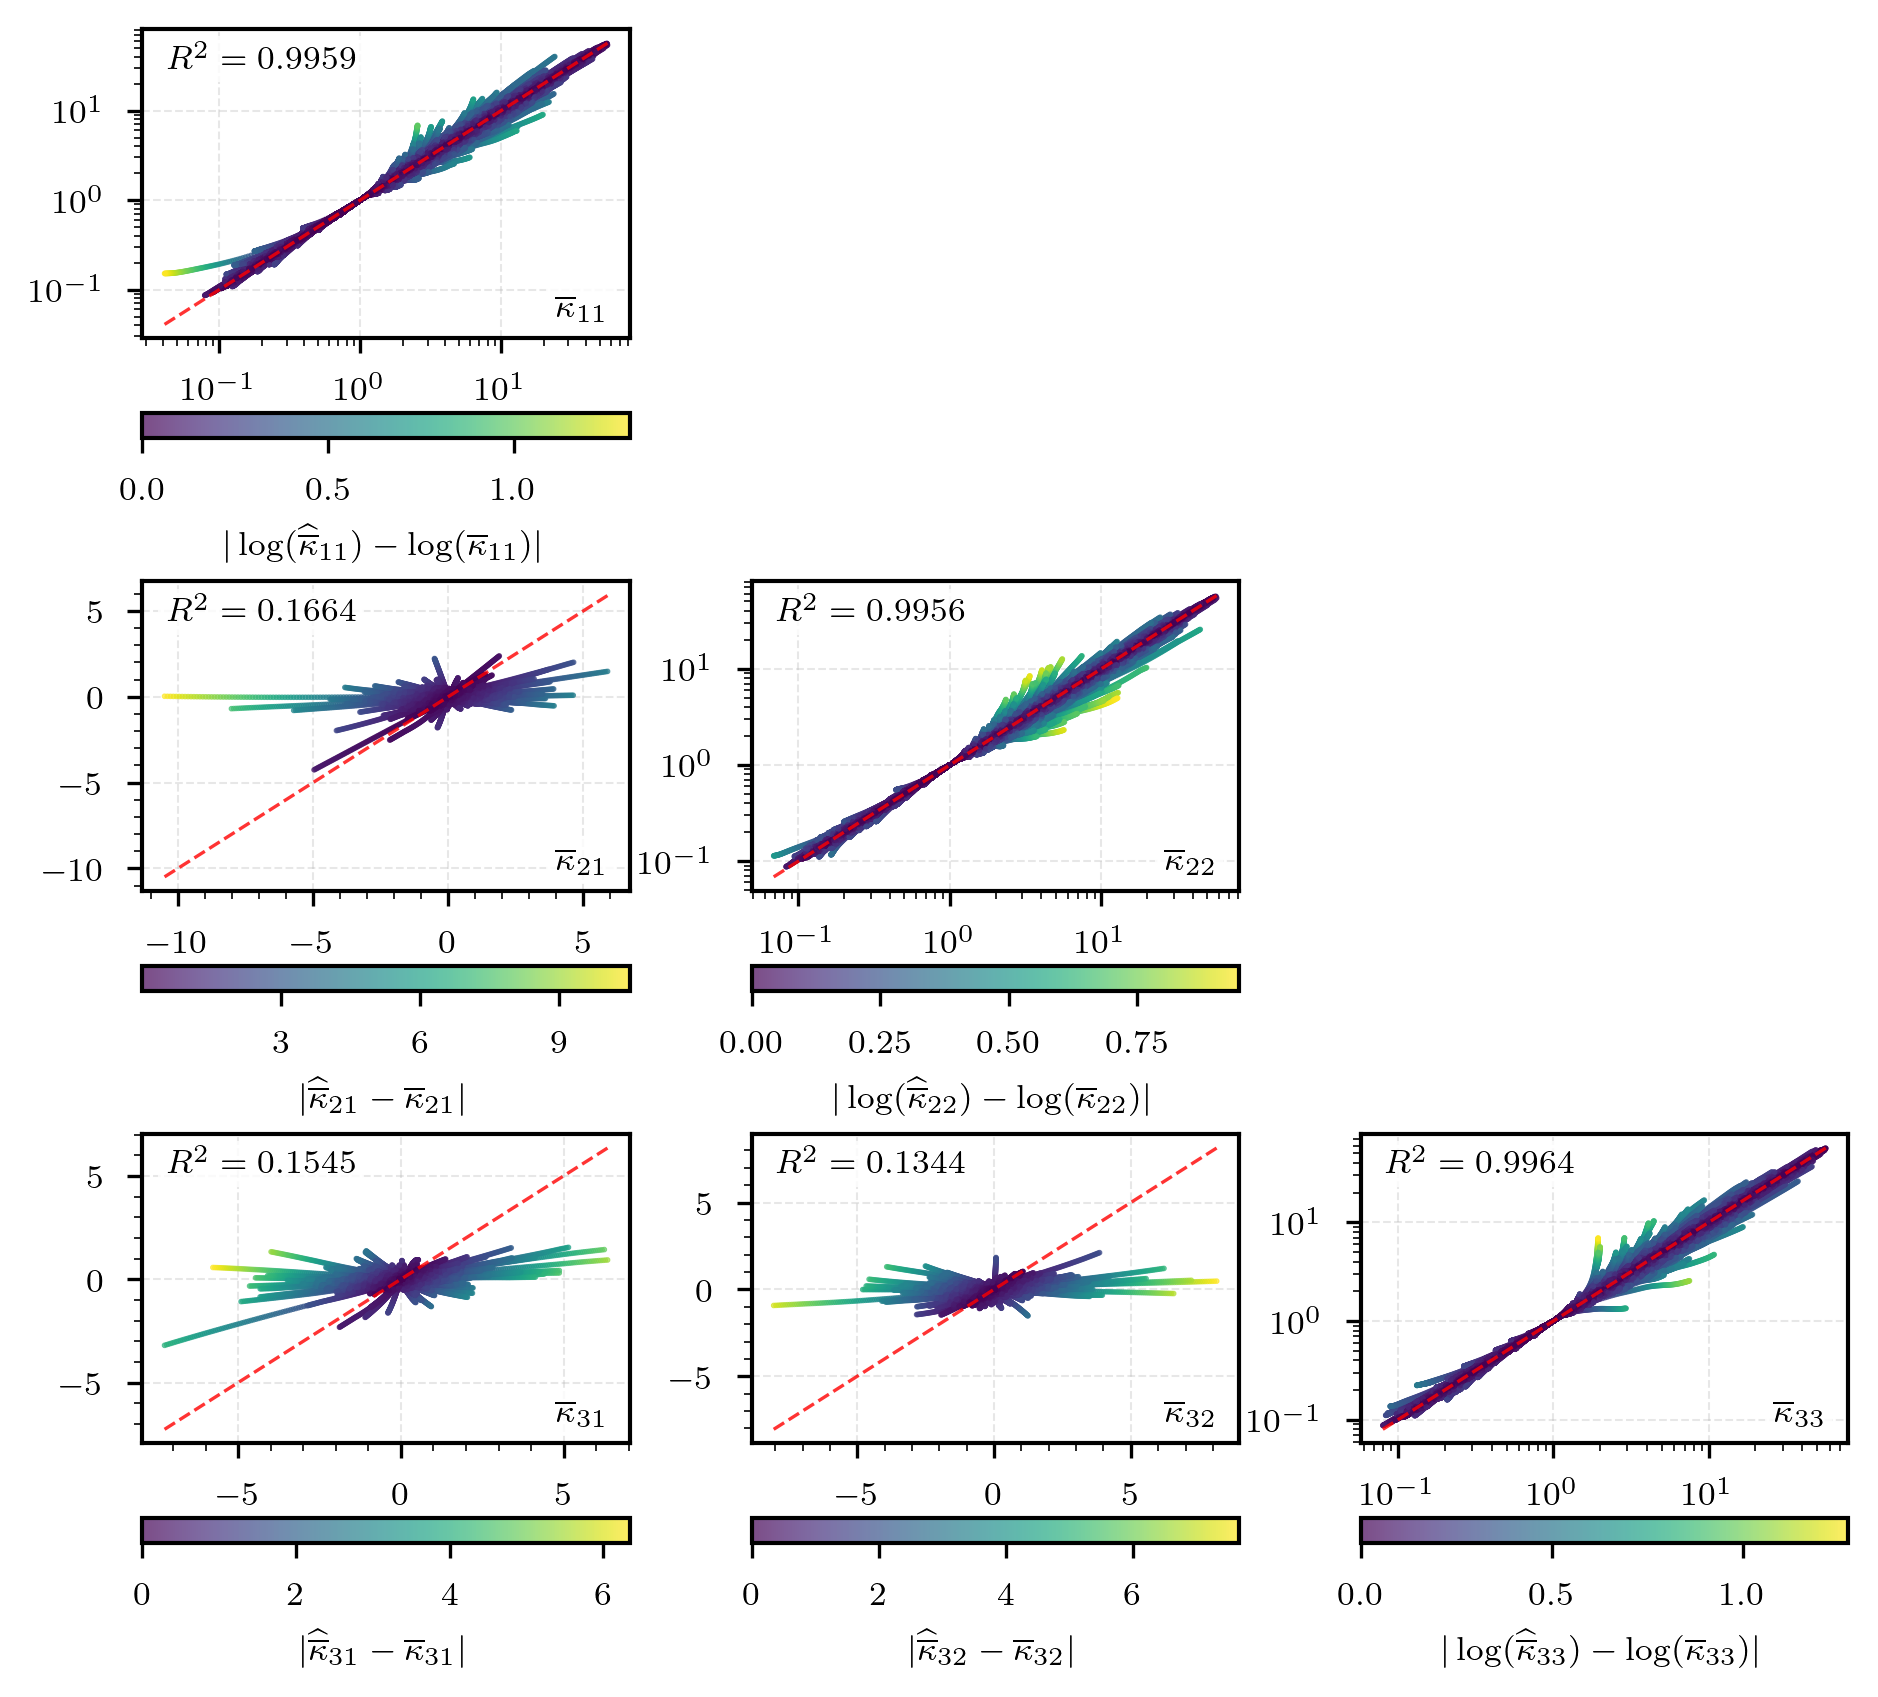

In [9]:
import matplotlib.cm as cm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import torch

# Set global fontsize
fontsize = 8
plt.style.use('seaborn-v0_8-paper')  # Clean, publication-style theme


def plot_predictions_v3(ax, y, pred, idx=0, error_type='absolute_log', norm=None):
    """Create scatter plot with color-coded prediction errors."""
    if ax is None:  # Skip if ax is None (for upper triangle)
        return
    
    y_sorted = y[:, idx]
    pred_sorted = pred[:, idx]

    # Calculate errors without normalization
    if error_type == 'absolute':
        error_plt = np.abs((pred_sorted - y_sorted).cpu().numpy())
    else:  # absolute_log
        error_plt = np.abs((torch.log(torch.abs(pred_sorted)) - torch.log(y_sorted)).cpu().numpy())

    # Create scatter plot with viridis colormap without normalization
    sc = ax.scatter(y_sorted.cpu().numpy(), 
                   pred_sorted.cpu().numpy(), 
                   c=error_plt,
                   cmap='viridis',
                   marker='.',
                   s=5, 
                   alpha=0.7)
    
    # Add diagonal reference line
    lims = [y_sorted.min().item(), y_sorted.max().item()]
    ax.plot(lims, lims, 'r--', alpha=0.8, linewidth=0.8)
    
    return sc, None, error_type

# Create figure and axes with standardized size
fig, axs = plt.subplots(3, 3, figsize=[6.3, 5.7], dpi=300, squeeze=False)  # Slightly taller figure

# LaTeX labels for tensor components
component_labels = [
    [r"$\overline{\kappa}_{11}$", r"", r""],
    [r"$\overline{\kappa}_{21}$", r"$\overline{\kappa}_{22}$", r""],
    [r"$\overline{\kappa}_{31}$", r"$\overline{\kappa}_{32}$", r"$\overline{\kappa}_{33}$"]
]

# Component indices mapping to the 6 outputs (11,22,33,12,13,23)
# For diagonal: 0,1,2 and for off-diagonal: 3,4,5
component_indices = [
    [0, None, None],
    [3, 1, None],
    [4, 5, 2]
]

# Error types for each position
error_types = [
    ['absolute_log', None, None],
    ['absolute', 'absolute_log', None],
    ['absolute', 'absolute', 'absolute_log']
]

# Filter validation data
mask = val_x[:, -1] > 0
val_pred_filtered = val_pred[mask].cpu()

# Calculate R² scores for all components
r2_scores = [r2_score(val_y[mask][:, i].cpu(), val_pred_filtered[:, i].cpu()) 
             for i in range(6)]

# Create subplots for components
scatter_objects = {}
for row in range(3):
    for col in range(3):
        ax = axs[row, col]
        
        # Skip upper triangular cells
        if row < col:
            ax.axis('off')
            continue
        
        idx = component_indices[row][col]
        error_type = error_types[row][col]
        comp_label = component_labels[row][col]
        
        # Plot with appropriate error metrics without normalization
        sc, _, err_type = plot_predictions_v3(ax, val_y[mask].cpu(), val_pred_filtered, 
                                             idx=idx, error_type=error_type)
        
        # Store scatter object for colorbars
        scatter_objects[(row, col)] = {'scatter': sc, 'error_type': err_type}
        
        # Add R² score annotation
        ax.text(0.05, 0.95, f"$R^2 = {r2_scores[idx]:.4f}$", 
                transform=ax.transAxes, fontsize=fontsize, verticalalignment='top',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, pad=2))
        
        # Add component label
        ax.text(0.95, 0.05, comp_label, 
                transform=ax.transAxes, fontsize=fontsize, 
                horizontalalignment='right', verticalalignment='bottom',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, pad=2))
        
        # Set axis scales and formatting
        if row == col:  # Diagonal elements: log scale
            ax.set_xscale('log')
            ax.set_yscale('log')

        ax.tick_params(labelbottom=True)
        ax.minorticks_on()
        
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        ax.set_axisbelow(True)
        
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Add colorbar at the bottom of each subplot
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="8%", pad=0.25)
        cbar = plt.colorbar(sc, cax=cax, orientation='horizontal')
        cbar.ax.tick_params(labelsize=fontsize)
        
        # Set colorbar label with component-specific labels
        if error_type == 'absolute_log':
            cbar.set_label(r'$|\log(\widehat{\overline{\kappa}}' + comp_label[18:-1] + r') - \log(' + comp_label[1:-1] + r')|$', fontsize=fontsize)
        else:
            cbar.set_label(r'$|\widehat{\overline{\kappa}}' + comp_label[18:-1] + r' - ' + comp_label[1:-1] + r'|$', fontsize=fontsize)
            
        # Adjust ticks as needed
        if row == 1 and col == 0:
            cbar.set_ticks([3, 6, 9])  # Only adjust ax[1,0] colorbar ticks to [3,6,9]


plt.tight_layout()
plt.subplots_adjust(hspace=0.35, wspace=0.25)  # Increased vertical space
plt.show()

# Save the figure with high quality
fig.savefig("../../overleaf/gfx/therm3d_predictions_matrix_view.png", 
            bbox_inches='tight', 
            dpi=600,
            metadata={'Creator': '', 'Producer': ''})


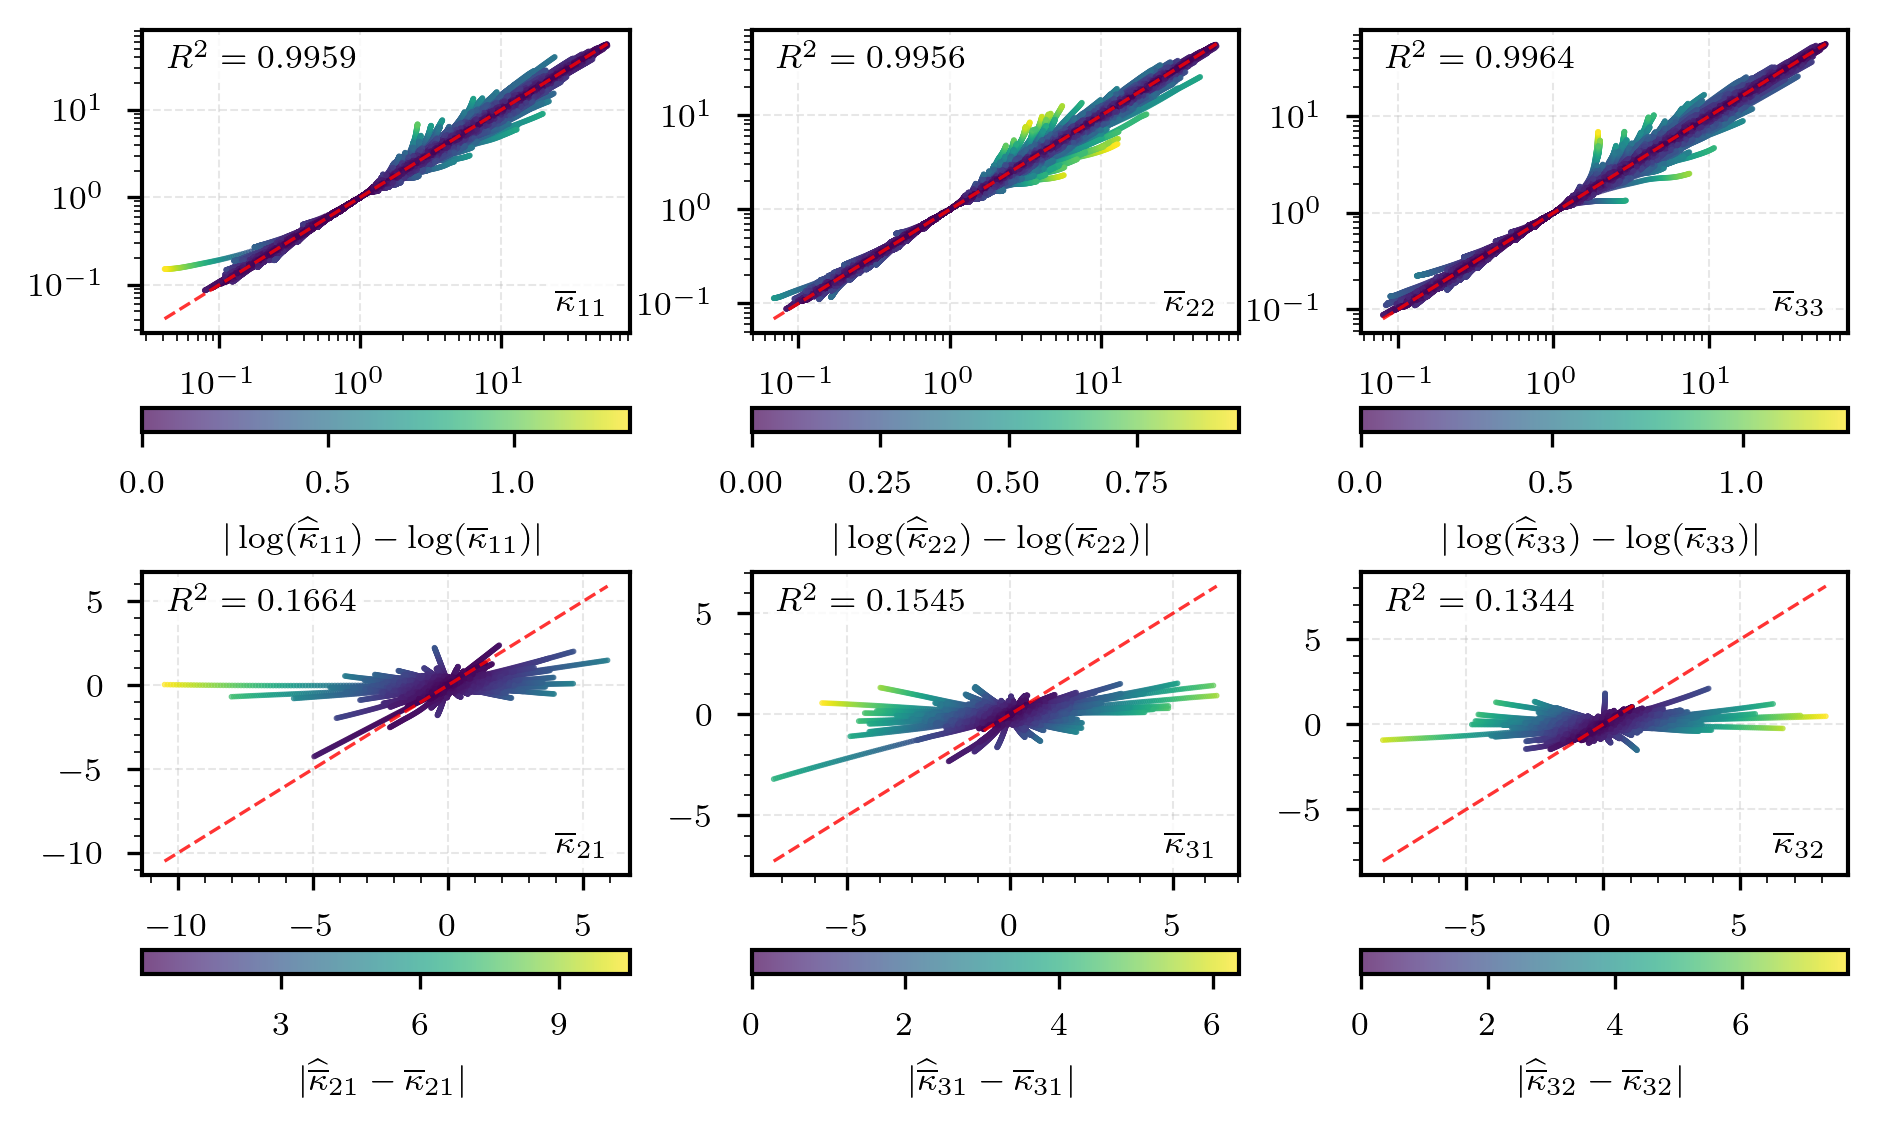

In [14]:
import matplotlib.cm as cm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import torch

# Set global fontsize
fontsize = 8
plt.style.use('seaborn-v0_8-paper')  # Clean, publication-style theme


def plot_predictions_v3(ax, y, pred, idx=0, error_type='absolute_log', norm=None):
    """Create scatter plot with color-coded prediction errors."""
    if ax is None:  # Skip if ax is None (for upper triangle)
        return
    
    y_sorted = y[:, idx]
    pred_sorted = pred[:, idx]

    # Calculate errors without normalization
    if error_type == 'absolute':
        error_plt = np.abs((pred_sorted - y_sorted).cpu().numpy())
    else:  # absolute_log
        error_plt = np.abs((torch.log(torch.abs(pred_sorted)) - torch.log(y_sorted)).cpu().numpy())

    # Create scatter plot with viridis colormap without normalization
    sc = ax.scatter(y_sorted.cpu().numpy(), 
                   pred_sorted.cpu().numpy(), 
                   c=error_plt,
                   cmap='viridis',
                   marker='.',
                   s=5, 
                   alpha=0.7)
    
    # Add diagonal reference line
    lims = [y_sorted.min().item(), y_sorted.max().item()]
    ax.plot(lims, lims, 'r--', alpha=0.8, linewidth=0.8)
    
    return sc, None, error_type

# Create figure and axes with standardized size
fig, axs = plt.subplots(2, 3, figsize=[6.3, 3.8], dpi=300, squeeze=False)  # Adjust height as needed

# LaTeX labels for tensor components
component_labels = [
    r"$\overline{\kappa}_{11}$", 
    r"$\overline{\kappa}_{22}$", 
    r"$\overline{\kappa}_{33}$",
    r"$\overline{\kappa}_{21}$", 
    r"$\overline{\kappa}_{31}$", 
    r"$\overline{\kappa}_{32}$"
]

# Indices mapping: Row 0 for diagonals (0,1,2), Row 1 for off-diagonals (3,4,5)
component_indices = [0, 1, 2, 3, 4, 5]

# Error types for each position (same pattern as original)
error_types = [
    'absolute_log', 'absolute_log', 'absolute_log', 
    'absolute', 'absolute', 'absolute'
]

# Filter validation data
mask = val_x[:, -1] > 0
val_pred_filtered = val_pred[mask].cpu()

# Calculate R² scores for all components
r2_scores = [r2_score(val_y[mask][:, i].cpu(), val_pred_filtered[:, i].cpu()) 
             for i in range(6)]

# Create subplots for components
scatter_objects = {}
for i in range(6):
    row = 0 if i < 3 else 1  # First row for diagonals, second row for off-diagonals
    col = i % 3
    idx = component_indices[i]
    error_type = error_types[i]
    comp_label = component_labels[i]
    
    ax = axs[row, col]
    
    # Plot with appropriate error metrics without normalization
    sc, _, err_type = plot_predictions_v3(ax, val_y[mask].cpu(), val_pred_filtered, 
                                         idx=idx, error_type=error_type)
    
    # Store scatter object for colorbars
    scatter_objects[(row, col)] = {'scatter': sc, 'error_type': err_type}
    
    # Add R² score annotation
    ax.text(0.05, 0.95, f"$R^2 = {r2_scores[idx]:.4f}$", 
            transform=ax.transAxes, fontsize=fontsize, verticalalignment='top',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, pad=2))
    
    # Add component label
    ax.text(0.95, 0.05, comp_label, 
            transform=ax.transAxes, fontsize=fontsize, 
            horizontalalignment='right', verticalalignment='bottom',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, pad=2))
    
    # Set axis scales and formatting
    if i < 3:  # Diagonal elements: log scale
        ax.set_xscale('log')
        ax.set_yscale('log')

    ax.tick_params(labelbottom=True)
    ax.minorticks_on()
    
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)
    
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Add colorbar at the bottom of each subplot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="8%", pad=0.25)
    cbar = plt.colorbar(sc, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize)
    
    # Set colorbar label with component-specific labels
    if error_type == 'absolute_log':
        cbar.set_label(r'$|\log(\widehat{\overline{\kappa}}_{' + comp_label[19:-1] + r'}) - \log(' + comp_label[1:-1] + r')|$', fontsize=fontsize)
    else:
        cbar.set_label(r'$|\widehat{\overline{\kappa}}_{' + comp_label[19:-1] + r'} - ' + comp_label[1:-1] + r'|$', fontsize=fontsize)
    
    # Adjust ticks for component 3 (previously ax[1,0]) to match original
    if i == 3:
        cbar.set_ticks([3, 6, 9])

plt.tight_layout()
plt.subplots_adjust(hspace=0.35, wspace=0.25)  # Maintain spacing from original
plt.show()

# Save the figure with high quality
fig.savefig("../../overleaf/gfx/therm3d_predictions_flattened_view.png", 
            bbox_inches='tight', 
            dpi=600,
            metadata={'Creator': '', 'Producer': ''})


In [ ]:
import matplotlib.pyplot as plt
import re
from matplotlib.ticker import LogLocator, NullFormatter


training_history_file = data_dir / 'Thermal3D_models/vrnn_therm3D_training_history_20250320_052451.out'

# Initialize lists to store the values
epochs, training_loss, validation_loss, learning_rates = [], [], [], []

# Read the file
with open(training_history_file, 'r') as file:
    for line in file:
        match = re.match(r'Epoch (\d+): training loss ([\d.]+), validation loss ([\d.]+), learning rate ([\d.e+-]+)', line)
        if match:
            epochs.append(int(match.group(1)))
            training_loss.append(float(match.group(2)))
            validation_loss.append(float(match.group(3)))
            learning_rates.append(float(match.group(4)))

# Hacky... scale training loss and validation loss by sqrt(2)
training_loss = np.array(training_loss) / np.sqrt(2)
validation_loss = np.array(validation_loss) / np.sqrt(2)

# Increase font size for readability
fontsize = 8
linewidth = 0.5

# Create a single figure with one axes
fig, ax1 = plt.subplots(figsize=(6.3/2, 2.5), dpi=600)

# Plot training and validation losses on the left y-axis with markers
l1, = ax1.plot(epochs, training_loss, '-', label='Training Loss', linewidth=linewidth)# , color='blue')
l2, = ax1.plot(epochs, validation_loss, '-', label='Validation Loss', linewidth=linewidth)# , color='red')
ax1.set_xlabel('Epoch $[-]$', fontsize=fontsize)
ax1.set_ylabel('Voigt-Reuss Normalized Loss $[-]$', fontsize=fontsize)
ax1.set_yscale('log')
ax1.set_ylim(4e-3, 1e0)
ax1.grid(which="both", ls="--", alpha=0.5, linewidth=0.3)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.legend(loc='lower left', fontsize=fontsize)

# Add minor ticks to the left axis for a smoother log scale
ax1.yaxis.set_minor_locator(LogLocator(subs='auto'))
ax1.yaxis.set_minor_formatter(NullFormatter())

# Create a twin axes to plot the learning rate decay on the right y-axis
ax2 = ax1.twinx()
l3, = ax2.plot(epochs, learning_rates, '-', color="grey", label='Learning Rate', linewidth=linewidth)
ax2.set_ylabel('Learning Rate $[-]$', fontsize=fontsize)
ax2.set_yscale('log')
ax2.set_ylim(2.5e-5, 2e-1)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.legend(loc='upper right', fontsize=fontsize)

ax2.set_xlim(-10, epochs[-1])
# Apply consistent style and layout
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1
plt.tight_layout()

plt.show()

# Save the figure with high quality
fig.savefig("../../overleaf/gfx/therm3d_vrnn_training_history.pdf", 
            bbox_inches='tight', 
            dpi=600,
            metadata={'Creator': '', 'Producer': ''})